In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import matplotlib.mlab as mlab
from matplotlib import cm
from scipy.interpolate import interp1d

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'

plt.rc('text', usetex=True) ## this line is necessary to use the correct fonts 
plt.rc('font', family='serif') # this line is necessary to use the correct font


# This function makes the plots pretty 
def plot_prop(f1,ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_position(('axes', -0.01))
    ax.spines['bottom'].set_position(('axes', -0.02))
    ax.xaxis.set_minor_locator(AutoMinorLocator(1))
    ax.yaxis.set_minor_locator(AutoMinorLocator(1))

    # x and y tickers
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.tick_params(direction='out',which='major', length=8,width=1.5,colors='k',labelsize=f1)
    plt.tick_params(direction='out',which='minor',length=4,width=1, color='k')
    return;


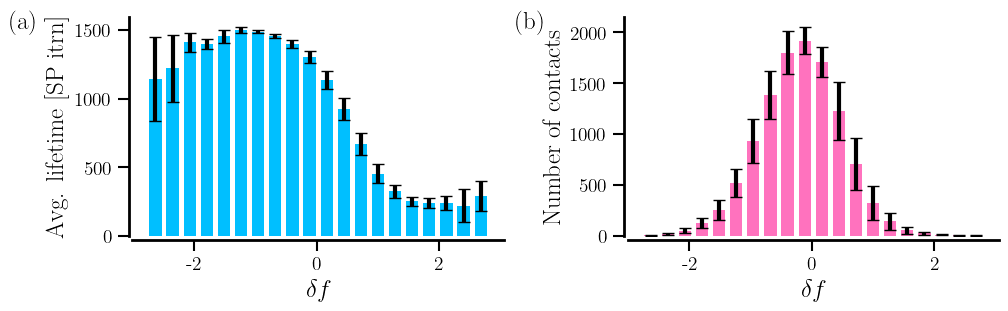

In [2]:
# LIFETIME

l1=1; f1=14; f2=16; f3=18  # the font sizes 
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(10,3)  # the size of the plot in inches 
gs = gridspec.GridSpec(1, 2, figure=fig)  # the gridspace, here I set 2 * 1

N=400
seeds = np.arange(1000,10001,1000)
n_divisions = 20
av_lftm_in_frdiff_range = np.zeros([len(seeds),n_divisions])
av_lftm_sd = np.zeros(n_divisions)
bins = 20
frdiff_end_binvalues = np.zeros([len(seeds),bins])

for j in range(len(seeds)):
    seed = seeds[j]
    lfdata = np.loadtxt("Data/Data_Fig16/lifetime_STDP+rSP(seed=%.1f)lf.dat"%(seed))
    total_lftm = lfdata[:N,:].flatten()
    n_gen = lfdata[N:2*N,:].flatten()
    end_frdiff = lfdata[2*N:,:].flatten()
    where_conn = np.where(n_gen != 0) # so that divide-by-zero does not occur
    total_lftm = total_lftm[where_conn]
    n_gen = n_gen[where_conn]
    av_lftm = total_lftm/n_gen
    end_frdiff = end_frdiff[where_conn]

    FRdata = np.loadtxt("Data/Data_Fig16/freqdiff_STDP+rSP(seed=%.1f)lf.dat"%(seed))
    fr = FRdata[0,:]
    frdiff = FRdata[1:,:].flatten() # uncoupled frequency difference between disconnected neurons
    frdiff = frdiff[where_conn]

    A = np.loadtxt("Data/Data_Fig16/A_STDP+rSP(seed=%.1f)lf.dat"%(seed))[2*N:,:]
    frdiff_end = FRdata[1:,:] # end does not mean end here, I just had to give it a different name
    frdiff_end = frdiff_end[np.where(A!=0)] # uncoupled frequency difference between only the connected neurons
    frdiff_end_binvalues[j], bin_edges = np.histogram(frdiff_end,bins=bins,density=False)

    # sorting the freq. difference array in ascending order and the average lifetime array accordingly
    sort_indices = np.argsort(frdiff)
    frdiff = frdiff[sort_indices]
    av_lftm = av_lftm[sort_indices]
    n_gen = n_gen[sort_indices]

    # stratifying the freq diff and average lifetime
    frdiff_range_mid = np.zeros(n_divisions)
    ngen_in_frdiff_range = np.zeros(n_divisions)

    # dividing the freq diff into bins and then calculating the average lifetime of contacts formed between pairs 
    # of neurons for which the freq diff lies within those bins
    for i in range(n_divisions): 
        fmin = min(frdiff)
        fmax = max(frdiff)
        df = (fmax-fmin)/n_divisions # step size for dividing freq diff into n_divisions
        beginfr = fmin + i*df 
        endfr = beginfr + df # freq diff between 'beginfr' and 'endfr' lie in one bin
        i1 = (np.abs(frdiff- beginfr)).argmin() # index where freq diff is closest to the 'beginfr'
        i2 = (np.abs(frdiff- endfr)).argmin() # index where freq diff is closest to the 'endfr'
        frdiff_range_mid[i] = (beginfr+endfr)/2 # putting the mean fr of the bin in the array
        av_lftm_in_frdiff_range[j,i] = np.mean(av_lftm[i1:i2])
        ngen_in_frdiff_range[i] = np.sum(n_gen[i1:i2])

av_lftm = np.mean(av_lftm_in_frdiff_range,axis=0)
av_lftm_sd = np.std(av_lftm_in_frdiff_range,axis=0)
frdiff_end_bin_av = np.mean(frdiff_end_binvalues,axis=0)
frdiff_end_bin_sd = np.std(frdiff_end_binvalues,axis=0)

ax = pl.subplot(gs[0])
plot_prop(f1,ax)
plt.bar(frdiff_range_mid,av_lftm,width=0.2,alpha=1,color='deepskyblue',yerr=av_lftm_sd,capsize=4)
plt.ylabel('Avg. lifetime [SP itrn]',fontsize=f3)
plt.xlabel(r'$\delta f$',fontsize=f3)
plt.text(-0.33,0.95,'(a)',fontsize=f3,transform=ax.transAxes)

ax = pl.subplot(gs[1])
plot_prop(f1,ax)
plt.bar(frdiff_range_mid,frdiff_end_bin_av,width=0.2,alpha=0.6,color='deeppink',yerr=frdiff_end_bin_sd,capsize=4)
plt.ylabel('Number of contacts',fontsize=f3)
plt.xlabel(r'$\delta f$',fontsize=f3)
plt.text(-0.3,0.95,'(b)',fontsize=f3,transform=ax.transAxes)

# plt.savefig("lifetime.jpg",dpi=600)
plt.show()